In [1]:
!pip install pretrainedmodels
!pip install optuna

     |████████████████████████████████| 58 kB 1.6 MB/s eta 0:00:011
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=926de4beaa7c6d1e9a906281c021dbbe9df4d8c9192e52a4347b30cd936f9dae
  Stored in directory: /root/.cache/pip/wheels/9c/03/81/494596f1d017bbf80daf53bc33dbb05aaa5a6ad6d44c74011f
Successfully built pretrainedmodels


In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import torch.nn.functional as F
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import pretrainedmodels
import os
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
import numpy as np
import pandas as pd
import os
import datetime as dt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models



%matplotlib inline

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


In [3]:
data_path = "../input/ammi-2020-convnets/train/train/"
test_path = "../input/ammi-2020-convnets/test/test"
extraimage_path = "../input/ammi-2020-convnets/extraimages/extraimages"

In [4]:
print('Train set:')
class_distrbution = {}
for cls in os.listdir(data_path):
    print('{}:{}'.format(cls, len(os.listdir(os.path.join(data_path, cls)))))
    class_distrbution[cls] =  len(os.listdir(os.path.join(data_path, cls)))
im = Image.open(data_path+'/cgm/train-cgm-738.jpg')
print(im.size)
class_distrbution

Train set:
cmd:2658
cgm:773
cbsd:1443
cbb:466
healthy:316
(500, 500)


{'cmd': 2658, 'cgm': 773, 'cbsd': 1443, 'cbb': 466, 'healthy': 316}

In [5]:
# Transformations for both the training and testing data
mean=[0.4543, 0.5137, 0.3240]
std=[0.1949, 0.1977, 0.1661]


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(331), #448, 299, 224, 331
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])

test_transforms = transforms.Compose([ transforms.Resize(331),
                                       transforms.CenterCrop(331),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])

# normalize = transforms.Normalize(mean=mean, std=std)

In [6]:


class CassavaDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform

        files = []
        class_names = {}
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])

                name = str(i)+'-'+className
                if name not in class_names:
                    class_names[name] = 1
                else:
                    class_names[name] += 1
        self.file_list = files
        print(class_names)
        files = None

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        
# #         return im.view(3, 448, 448), classCategory
#         return im.view(3, 224, 224), classCategory
# #         return im.view(3, 299, 299), classCategory
        return im.view(3, 331, 331), classCategory   # NASNetLarge 331x331

In [7]:
train_data = CassavaDataset(data_path, transform=train_transforms)

test_data = CassavaDataset(test_path, transform=test_transforms)

extraimage_data = CassavaDataset(extraimage_path, transform=train_transforms) #maybe need an other trasforms, I had to change the dataset structure :)

{'0-cmd': 2658, '1-cgm': 773, '2-cbsd': 1443, '3-cbb': 466, '4-healthy': 316}
{'0-0': 3774}
{}


In [8]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_split = 0.2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [9]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
                                             sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
                                             sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1) 

In [10]:
# for data,label in valid_loader:
#     print(label)
#     break
# #     

In [11]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

tensor([2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 3, 0, 2, 4, 2, 3, 0, 2, 3, 2, 2, 0, 2, 0,
        2, 2, 2, 4, 0, 2, 3, 1])


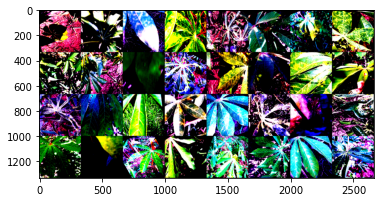

In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(labels)
img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)

In [13]:

class Additional(nn.Module):
    def __init__(self, modelA,in_features,nb_classes=5,drop=0.1):
        super(Additional, self).__init__()
        self.modelA = modelA
        # Remove last linear layer
        self.modelA.last_linear = nn.Identity()
        
        for p in self.modelA.parameters():
            p.requires_grad = False
        
        # Create new classifier
        self.fc_1 = nn.Linear(51200,1024)
        self.fc_2 = nn.Linear(1024,  512)
        self.fc_out = nn.Linear( 512, nb_classes)
        
        #Dropout
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        #model
        x = self.modelA(x)  
        x = x.view(x.size(0), -1)
        
        #FC
        x  = self.dropout(F.relu(self.fc_1(x)))
        x = self.dropout(F.relu(self.fc_2(x)))
        x = self.fc_out(x)
        
        return x

In [14]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch,device):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
#         print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
            
            
        
    return train_loss.avg, train_acc.avg

In [23]:
def validate(val_loader, model, criterion, optimizer, epoch,device):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [24]:
def test(test_loader,train_loader, model):
    model.eval()
    pred = []
    _class_labels = np.array(train_loader.dataset.classes)
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, _ = data
            images = Variable(images).to(device)
    
            outputs = model(images)
    
            prediction = outputs.data.cpu().numpy().argmax()
            
            _predicted_class_labels = _class_labels[prediction]
            
            pred.append(_predicted_class_labels)

    return pred

In [25]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = pretrainedmodels.se_resnext50_32x4d(num_classes=1000, pretrained="imagenet")
   
# # model.last_linear.in_features
# # model.last_linear=nn.Identity()
# # model = Additional(model,model.last_linear.in_features,drop=0.3)
# # model = model.to(device)
# model



In [26]:

#     model = Additional(model,num_fits)
#     model = model.to(device)
    
#     class_weights = [class_distrbution[i] for i in train_loader.dataset.classes]
#     class_weights_normalized = [max(class_weights)/i for i in class_weights]

#     class_weights_normalized,torch.Tensor(class_weights_normalized)

#     weights = torch.Tensor(class_weights_normalized)
#     weights = weights.to(device)
    
    
#     criterion = nn.CrossEntropyLoss(weight = weights)
#     optimizer = optim.Adam(model.parameters())
    
#     epoch_num = 15
#     best_val_acc = 0.60
#     total_loss_val, total_acc_val = [],[]
#     for epoch in range(1, epoch_num+1):
#         loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#         loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, epoch)
#         total_loss_val.append(loss_val)
#         total_acc_val.append(acc_val)
#         if acc_val > best_val_acc:
#             best_val_acc = acc_val
#             torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
#             print('*****************************************************')
#             print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
#             print('*****************************************************')

In [27]:
def objective(trial):
    
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    drop  = trial.suggest_loguniform('drop', 0.1, 0.5)
    
#     model = model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet18', pretrained=True)

    model = pretrainedmodels.se_resnext50_32x4d(num_classes=1000, pretrained="imagenet")
    model_name = 'se_resnext50_32x4d'

    model = Additional(model,model.last_linear.in_features,drop=drop)
    model = model.to(device)
    
    class_weights = [class_distrbution[i] for i in train_loader.dataset.classes]
    class_weights_normalized = [max(class_weights)/i for i in class_weights]

    class_weights_normalized,torch.Tensor(class_weights_normalized)

    weights = torch.Tensor(class_weights_normalized)
    weights = weights.to(device)
    
    
    
    
    lr  = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    optim_ = trial.suggest_categorical('optim_',[optim.SGD, optim.RMSprop,optim.Adam])
    momentum = trial.suggest_uniform('momentum', 0.4, 0.99)
    optimizer = optim_(model.parameters(), lr=lr)
    
    
    
    criterion = nn.CrossEntropyLoss(weight = weights)
    
    epoch_num = 5
    best_val_acc = 0.85
    total_loss_val, total_acc_val = [],[]
    for epoch in range(1, epoch_num+1):
        loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch,device)
        loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, epoch,device)
        total_loss_val.append(loss_val)
        total_acc_val.append(acc_val)
        if acc_val > best_val_acc:
            best_val_acc = acc_val
            torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
            print('*****************************************************')
            
     # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
            
    return acc_val

In [ ]:
import optuna

sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(func=objective, n_trials=20)

## Sumission

In [ ]:
class_names = {0:'cbsd', 1: 'cgm', 2: 'cbb', 3: 'healthy', 4: 'cmd'}

In [ ]:
def process_image(image_dir):
    # Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    image = Image.open(image_dir)
    preprocess = transforms.Compose([ transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])
    image = preprocess(image)
    # Convert 2D image to 1D vector
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)
    inputs = image.to(device)
    return inputs

In [ ]:
# Using our model to predict the label
def predict(image, model):
    # Pass the image through our model
    output = model(image)
    # Reverse the log function in our output
    output = torch.exp(output)
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [ ]:
test_directory = "./data/test/test/0"
predictions, test_image_fileName = [], []
try:
    test_images = listdir(test_directory)
    for images in test_images:
        test_image_fileName.append(images)
        image = process_image(f'{test_directory}/{images}')
        top_prob, top_class = predict(image, model)
        predictions.append(class_names[top_class])
except Exception as e:
    print(e)

In [ ]:
print("[INFO] Creating pandas dataframe")
submission_data = {"Category":predictions,"Id":test_image_fileName,}
submission_data_frame = pd.DataFrame(submission_data)

In [ ]:
submission_data_frame.head()

In [ ]:
submission_data_frame.to_csv('submission'+model_name+'_freeze_86_flip.csv', header=True, index=False)